 ## Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Models
import xgboost as xgb

# Keras / TensorFlow for Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, TFAutoModel

# Set plotting style
sns.set_style("whitegrid")

## Load preprocessed data

In [10]:
df = pd.read_csv('sri_lanka_election_tweets_analysis_ready.csv')

print("Data loaded successfully.")
df

Data loaded successfully.


,id,created_at,target_politicians,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,engagement,weighted_polarity
0,1933555774984245308,Fri Jun 13 16:03:15 +0000 2025,Anura Kumara Dissanayake,Twitter for iPhone,@GurenDingin5 Thanks. I enjoy writing the page...,Thanks. I enjoy writing the pages akd see the...,Positive,0.075000,0.475000,en,1,0,344365428,False,[],['GurenDingin5'],Land of Lagom,NaN,2,0.150000
1,1933549625275003025,Fri Jun 13 15:38:48 +0000 2025,Anura Kumara Dissanayake,Twitter for iPhone,@DON_AKD @IsItOutEa @EASPORTSCollege They like...,They like to withhold information so that y...,Neutral,0.000000,0.000000,en,1,0,1496700372659826688,False,[],"['DON_AKD', 'IsItOutEa', 'EASPORTSCollege']",NaN,NaN,2,0.000000
2,1933547017755894258,Fri Jun 13 15:28:27 +0000 2025,Anura Kumara Dissanayake,Twitter for iPhone,@NoCCPGenocide @One_BCHQ I agree we need to se...,I agree we need to see some rubber on the ro...,Negative,-0.097222,0.313889,en,0,0,1622360846398799873,False,[],"['NoCCPGenocide', 'One_BCHQ', 'bcndp']","British Columbia, Canada",NaN,1,-0.097222
3,1933545480300249268,Fri Jun 13 15:22:20 +0000 2025,Ranil Wickremesinghe,Twitter for iPhone,Like this tweet to piss off a Ranil Rajapaksha...,Like this tweet to piss off a Ranil Rajapaksha...,Neutral,0.000000,0.000000,en,11,0,1148434888904679424,False,[],[],NaN,NaN,12,0.000000
4,1933533234442203589,Fri Jun 13 14:33:41 +0000 2025,Anura Kumara Dissanayake,Twitter for iPhone,The Business Forum organised by the Associatio...,The Business Forum organised by the Associatio...,Neutral,0.000000,0.000000,en,0,0,1190901200415154176,False,"['lka', 'SriLanka', 'Germany']",[],Sri Lanka,NaN,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1928507090659692608,Fri May 30 17:41:34 +0000 2025,Ranil Wickremesinghe,Twitter for iPhone,the initiator of this fight against corruption...,the initiator of this fight against corruption...,Neutral,0.000000,0.000000,en,4,0,1522215769626447875,False,[],[],NaN,NaN,5,0.000000
1456,1928506957603725543,Fri May 30 17:41:03 +0000 2025,Ranil Wickremesinghe,Twitter for iPhone,All these Ranilists are trying their level bes...,All these Ranilists are trying their level bes...,Positive,0.500000,0.300000,en,12,1,1522215769626447875,False,[],[],NaN,NaN,14,7.000000
1457,1928504374432591985,Fri May 30 17:30:47 +0000 2025,Ranil Wickremesinghe,Twitter for iPhone,@nadeesha111 @UNPunOfficial If Ranil is the on...,If Ranil is the one who's the initiator of a...,Positive,0.125000,0.291667,en,1,0,1522215769626447875,False,[],"['nadeesha111', 'UNPunOfficial']",NaN,NaN,2,0.250000
1458,1928498217639096691,Fri May 30 17:06:19 +0000 2025,Anura Kumara Dissanayake,Twitter for iPhone,🚨 Germany to press Sri Lanka on human rights d...,🚨 Germany to press Sri Lanka on human rights d...,Positive,0.072222,0.222222,en,4,3,211116487,False,[],[],NaN,NaN,8,0.577778


## Feature Engineering and Target Variable Setup

In [11]:
# Define numerical and text features
numerical_features = ['retweet_count', 'favorite_count', 'engagement']
text_feature = 'clean_text'

# Target Variable (y)
# We want to predict the sentiment
target = 'sentiment'

# Use LabelEncoder to convert sentiment strings to integers
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df[target])

# Check the mapping
print("Sentiment Label Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# Features (X) and Target (y)
y = df['sentiment_encoded']
X = df[[text_feature] + numerical_features]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Sentiment Label Mapping:
0: Negative
1: Neutral
2: Positive

Training set shape: (1168, 4)
Test set shape: (292, 4)


# Model 1: XGBoost
This model will establish our performance benchmark. We'll use Scikit-learn's Pipeline and ColumnTransformer to create a clean, reproducible workflow for handling our hybrid (text + numerical) data.

## Define the Preprocessing Pipeline
We need to process the text and numerical columns differently. A ColumnTransformer is the perfect tool for this.

In [12]:
# Transformer for numerical data: We will scale the data to have a mean of 0 and a standard deviation of 1.
numeric_transformer = StandardScaler()

# Transformer for text data: We will convert the text into numerical vectors using TF-IDF.
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Create the ColumnTransformer to apply these steps to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## Define the Full XGBoost Model Pipeline
we chain our preprocessor with the XGBoost classifier. A Pipeline ensures that all steps are performed in order and that the same transformations are applied to both the training and test data, preventing data leakage.

In [13]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',  # Objective for multi-class classification
        eval_metric='mlogloss',        # Evaluation metric for the objective
        use_label_encoder=False,     # Suppress a deprecation warning
        random_state=42              # For reproducibility
    ))
])
print("XGBoost model pipeline defined.")

XGBoost model pipeline defined.


## Train the XGBoost Model

In [14]:
xgb_pipeline.fit(X_train, y_train)
print("Model training complete.")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.


## Evaluate the XGBoost Model


--- XGBoost Model Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.46      0.58        54
     Neutral       0.62      0.79      0.70       124
    Positive       0.75      0.68      0.71       114

    accuracy                           0.68       292
   macro avg       0.72      0.64      0.66       292
weighted avg       0.70      0.68      0.68       292


Generating Confusion Matrix...


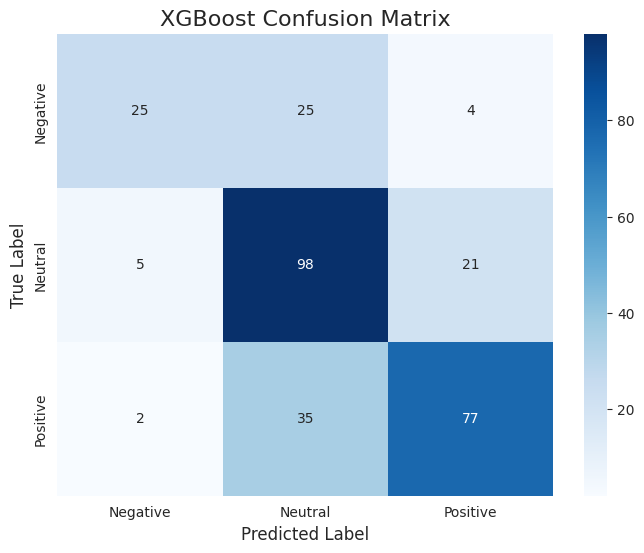

In [15]:
print("\n--- XGBoost Model Evaluation on Test Set ---")

y_pred_xgb = xgb_pipeline.predict(X_test)

# Print the classification report, which gives us precision, recall, and f1-score.
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# Visualize the performance with a Confusion Matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_xgb, labels=label_encoder.transform(label_encoder.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('XGBoost Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Model 2: TRANSFORMER (DISTILBERT) + NUMERICAL HYBRID MODEL
For speed and efficiency, we'll use DistilBERT. It's a smaller, faster version of BERT that retains most of its performance

## Define the model

In [16]:
MODEL_NAME = 'distilbert-base-uncased'

## Tokenize the Text Data for the Transformer

In [17]:
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Define the max sequence length. Tweets are short, so 128 is a safe and generous choice.
MAX_LENGTH = 128

# Tokenize the training text, creating TensorFlow tensors as output.
print("Tokenizing training text...")
X_train_tokens = tokenizer(
    X_train['clean_text'].tolist(),
    padding='max_length',  # Pad all sequences to MAX_LENGTH
    truncation=True,       # Truncate sequences longer than MAX_LENGTH
    max_length=MAX_LENGTH,
    return_tensors='tf'
)

# Tokenize the testing text using the same tokenizer and settings.
print("Tokenizing test text...")
X_test_tokens = tokenizer(
    X_test['clean_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors='tf'
)

Loading tokenizer for 'distilbert-base-uncased'...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing training text...
Tokenizing test text...


## Scale the Numerical Data for the Neural Network

In [19]:
print("Scaling numerical features for the neural network...")
numeric_scaler_nn = StandardScaler()
X_train_numeric_scaled = numeric_scaler_nn.fit_transform(X_train[numerical_features])
X_test_numeric_scaled = numeric_scaler_nn.transform(X_test[numerical_features])

print("Data preparation for the neural network is complete.")

Scaling numerical features for the neural network...
Data preparation for the neural network is complete.


## Build the Hybrid Neural Network Architecture

In [24]:
def create_hybrid_model(num_labels, model_name=MODEL_NAME):
    """
    Creates a hybrid neural network using a pre-trained Transformer for text
    and a simple Dense network for numerical features.
    (This version includes a Lambda layer to handle KerasTensor issues)
    """

    # Load the pre-trained Transformer model first
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_model.trainable = False

    # Text Input Branch
    text_input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
    text_attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')

    transformer_output = tf.keras.layers.Lambda(
        lambda x: transformer_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(MAX_LENGTH, transformer_model.config.hidden_size),
        name='transformer_lambda'
    )([text_input_ids, text_attention_mask])

    # Extract the [CLS] token's output as before.
    transformer_cls_token = transformer_output[:, 0, :]

    # Numerical Input Branch
    numeric_input = tf.keras.layers.Input(shape=(len(numerical_features),), name='numeric_input')
    numeric_dense = tf.keras.layers.Dense(32, activation='relu')(numeric_input)

    # Concatenate and Classify
    concatenated = tf.keras.layers.Concatenate()([transformer_cls_token, numeric_dense])
    x = tf.keras.layers.Dropout(0.2)(concatenated)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(num_labels, activation='softmax', name='output_layer')(x)

    # Build and Compile
    model = tf.keras.Model(inputs=[text_input_ids, text_attention_mask, numeric_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Create the model instance

In [25]:
num_classes = len(label_encoder.classes_)
hybrid_model = create_hybrid_model(num_labels=num_classes)

# Print a summary of the model architecture to see all the layers and parameter counts.
print("\n--- Hybrid Model Architecture Summary ---")
hybrid_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



--- Hybrid Model Architecture Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_lambda  │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 768)       │          0 │ transformer_lamb… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 800)       │          0 │ get_item_1[0][0], │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 800)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    102,528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 3)         │        387 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,043 (402.51 KB)

 Trainable params: 103,043 (402.51 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Hybrid Model

In [26]:
train_inputs = {
    'input_ids': X_train_tokens['input_ids'],
    'attention_mask': X_train_tokens['attention_mask'],
    'numeric_input': X_train_numeric_scaled
}
test_inputs = {
    'input_ids': X_test_tokens['input_ids'],
    'attention_mask': X_test_tokens['attention_mask'],
    'numeric_input': X_test_numeric_scaled
}

print("\n--- Training the Transformer Hybrid Model ---")
# We will train for 5 epochs.
history = hybrid_model.fit(
    train_inputs,
    y_train,
    validation_data=(test_inputs, y_test),
    epochs=5,
    batch_size=32
)



--- Training the Transformer Hybrid Model ---
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 385s 10s/step - accuracy: 0.3650 - loss: 1.1875 - val_accuracy: 0.4863 - val_loss: 1.0295
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 358s 10s/step - accuracy: 0.4389 - loss: 1.0694 - val_accuracy: 0.5034 - val_loss: 1.0147
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 349s 9s/step - accuracy: 0.4446 - loss: 1.0609 - val_accuracy: 0.5068 - val_loss: 1.0035
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step - accuracy: 0.4593 - loss: 1.0410 - val_accuracy: 0.5000 - val_loss: 0.9934
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step - accuracy: 0.4859 - loss: 1.0011 - val_accuracy: 0.5137 - val_loss: 0.9849


## Evaluate Transformer Hybrid Model


--- Transformer Hybrid Model Evaluation ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        54
     Neutral       0.55      0.59      0.57       124
    Positive       0.48      0.68      0.56       114

    accuracy                           0.51       292
   macro avg       0.34      0.42      0.38       292
weighted avg       0.42      0.51      0.46       292


Generating Confusion Matrix...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


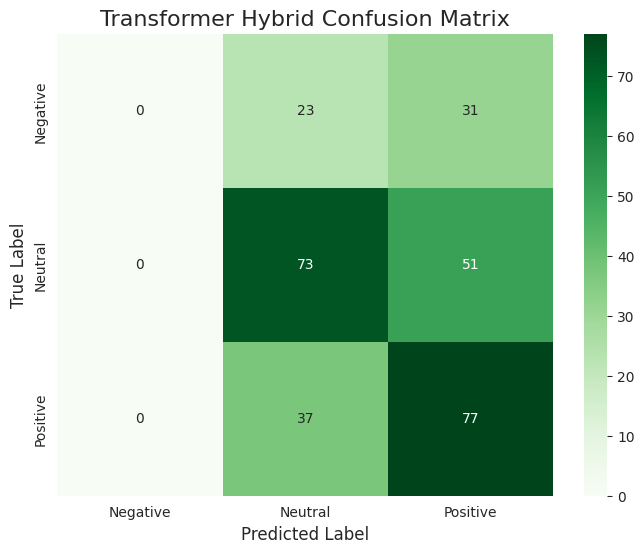

In [27]:
print("\n--- Transformer Hybrid Model Evaluation ---")

# predictions on the test set.
y_pred_probs_nn = hybrid_model.predict(test_inputs)

# use np.argmax to find the index (0, 1, or 2) of the class with the highest probability.
y_pred_nn = np.argmax(y_pred_probs_nn, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_nn, target_names=label_encoder.classes_))


# Visualize the performance with a Confusion Matrix
print("\nGenerating Confusion Matrix...")
cm_nn = confusion_matrix(y_test, y_pred_nn, labels=label_encoder.transform(label_encoder.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Transformer Hybrid Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


# Save the XGBoost Model and Components

In [28]:
import joblib

# We will save our trained XGBoost pipeline. This single object contains all the
# preprocessing steps (scaler, tf-idf) and the trained classifier.
model_filename = 'xgb_sentiment_pipeline.pkl'
joblib.dump(xgb_pipeline, model_filename)

# We also need to save the LabelEncoder, which allows us to convert the model's
# numerical output (0, 1, 2) back into human-readable labels ('Negative', 'Neutral', 'Positive').
encoder_filename = 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)

print("--- Model and components saved successfully! ---")
print(f"Trained XGBoost Pipeline saved to: {model_filename}")
print(f"Label Encoder saved to: {encoder_filename}")
print("\nWe are now ready to build the Streamlit UI.")

--- Model and components saved successfully! ---
Trained XGBoost Pipeline saved to: xgb_sentiment_pipeline.pkl
Label Encoder saved to: label_encoder.pkl

We are now ready to build the Streamlit UI.
